In [1]:
from timeit import default_timer as timer
# from numba import jit

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import *
from src.BlackScholes import *
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel, RBF, Sum, Product
# Laplacian, polynomial
import scipy as sp
from scipy import stats  


from pyblackscholesanalytics.market.market import MarketEnvironment
from pyblackscholesanalytics.options.options import PlainVanillaOption, DigitalOption
from pyblackscholesanalytics.utils.numeric_routines import NumericGreeks
from pyblackscholesanalytics.utils.utils import plot

import gpflow
import os
import warnings
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
warnings.filterwarnings("ignore")

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
np.random.seed(1234)

In [3]:
from datetime import datetime
from dateutil.relativedelta import relativedelta

def time2mat(T):
    # Define the initial date
    initial_date = datetime(2020, 4, 19)

    # Split T into years and months
    years_to_add = int(T)
    months_to_add = int((T - years_to_add) * 12)

    # Calculate the new date by adding years and months
    new_date = initial_date + relativedelta(years=years_to_add, months=months_to_add)

    # Format the new date as a string in the desired format
    new_date_str = new_date.strftime("%d-%m-%Y")

    return new_date_str

""" Simulate dynamics under GBM """ 
def gbm(S0, mu, sigma, T = 1., N = 10, M= 1000): 
    
    dt = T/ float(N) 
    S= np.array([S0]*(N+1)*M, dtype='float32').reshape(N+1, M)  
       
    for i in range(N):      
        dS = S[i,]*(mu*dt +  sigma*np.sqrt(dt)*np.random.randn(M))
        S[i+1,]=S[i,] + dS 
    
    return S

def chebyshev_nodes(n):
    return np.cos((2 * np.arange(1, n + 1) - 1) / (2 * n) * np.pi)

In [4]:
r = 0.0002  # risk-free rate
S = 100      # Underlying spot
S0 = 100      # Underlying spot

KC = 130    # Call strike
KP = 70     # Put strike
sigma = 0.4 # implied volatility
T = 2.0     # Time to maturity

option_f = PlainVanillaOption # PlainVanillaOption # DigitalOption

# 1 - GP pricer

In [5]:
lb = 0.001           # lower bound on domain
ub = 300             # upper bound on domain
training_number = 5  # Number of training samples
testing_number = 100 # Number of testing samples
sigma_n = 1e-8 # additive noise in GP

smart_sampling = False # True for chebychev nodes sample, False for uniform sample

In [6]:
# define the call and put prices using the BS model
option_call = option_f(MarketEnvironment(sigma=sigma), option_type="call", K=KC, T=time2mat(T))
option_put = option_f(MarketEnvironment(sigma=sigma), option_type="put", K=KC, T=time2mat(T))

price_call = lambda x: option_call.price(lb+(ub-lb)*x, T, True)
price_put = lambda x: option_put.price(lb+(ub-lb)*x, T, True)

Initializing the MarketEnvironment!
Initializing the EuropeanOption!
Initializing the MarketEnvironment!
Initializing the EuropeanOption!


## 2.1.1 - Call

In [7]:
# Uniform sample
if not(smart_sampling):
    train_x_1 = np.array(np.linspace(0,1, training_number), dtype='float64').reshape(training_number, 1)
    train_y_1 = price_call(train_x_1.flatten()).astype('float64')
        
    test_x_1 = np.array(np.linspace(0,1, testing_number), dtype='float64').reshape(testing_number, 1)
    test_y_1 = price_call(test_x_1.flatten()).astype('float64')

# Chebychev sample
else:
    def chebyshev_nodes(n):
        return np.cos((2 * np.arange(1, n + 1) - 1) / (2 * n) * np.pi)

    train_x_1_cheb = np.array(chebyshev_nodes(training_number), dtype='float64').reshape(training_number, 1)
    arr_min = np.min(train_x_1_cheb)
    arr_max = np.max(train_x_1_cheb)
    train_x_1 = ((train_x_1_cheb - arr_min) / (arr_max - arr_min))[::-1]

    train_y_1 = price_call(train_x_1.flatten()).astype('float64')
    where_are_NaNs = np.isnan(train_y_1)
    train_y_1[where_are_NaNs] = 0
        

    test_x_1_cheb = np.array(chebyshev_nodes(testing_number), dtype='float64').reshape(testing_number, 1)
    arr_min = np.min(test_x_1_cheb)
    arr_max = np.max(test_x_1_cheb)
    test_x_1 = ((test_x_1_cheb - arr_min) / (arr_max - arr_min))[::-1]

    test_y_1 = price_call(test_x_1.flatten()).astype('float64')
    where_are_NaNs = np.isnan(test_y_1)
    test_y_1[where_are_NaNs] = 0

### GPflow

In [8]:
kernel_name = 'Polynomial'
model = gpflow.models.GPR(
    (train_x_1, train_y_1.reshape(training_number, 1)),
    kernel=gpflow.kernels.Polynomial(), # SquaredExponential(),
)

opt = gpflow.optimizers.Scipy()
_ = opt.minimize(model.training_loss, model.trainable_variables)


# model.predict_f(test_x_1)
# model.predict_y(test_x_1)

In [9]:
y_pred_1, sigma_1 = model.predict_y(test_x_1)

In [10]:
y_pred_1_tf = y_pred_1.numpy().flatten()
sigma_1_tf = sigma_1.numpy().flatten()

### Sk GP

In [11]:
sk_kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-05, 1000.0))  #100000.0
gp = gaussian_process.GaussianProcessRegressor(kernel=sk_kernel, n_restarts_optimizer=20)
gp.fit(train_x_1,train_y_1)

GaussianProcessRegressor(kernel=RBF(length_scale=1), n_restarts_optimizer=20)

In [12]:
y_pred_1_sp, sigma_1_sp = gp.predict(test_x_1, return_std=True)

### Plot

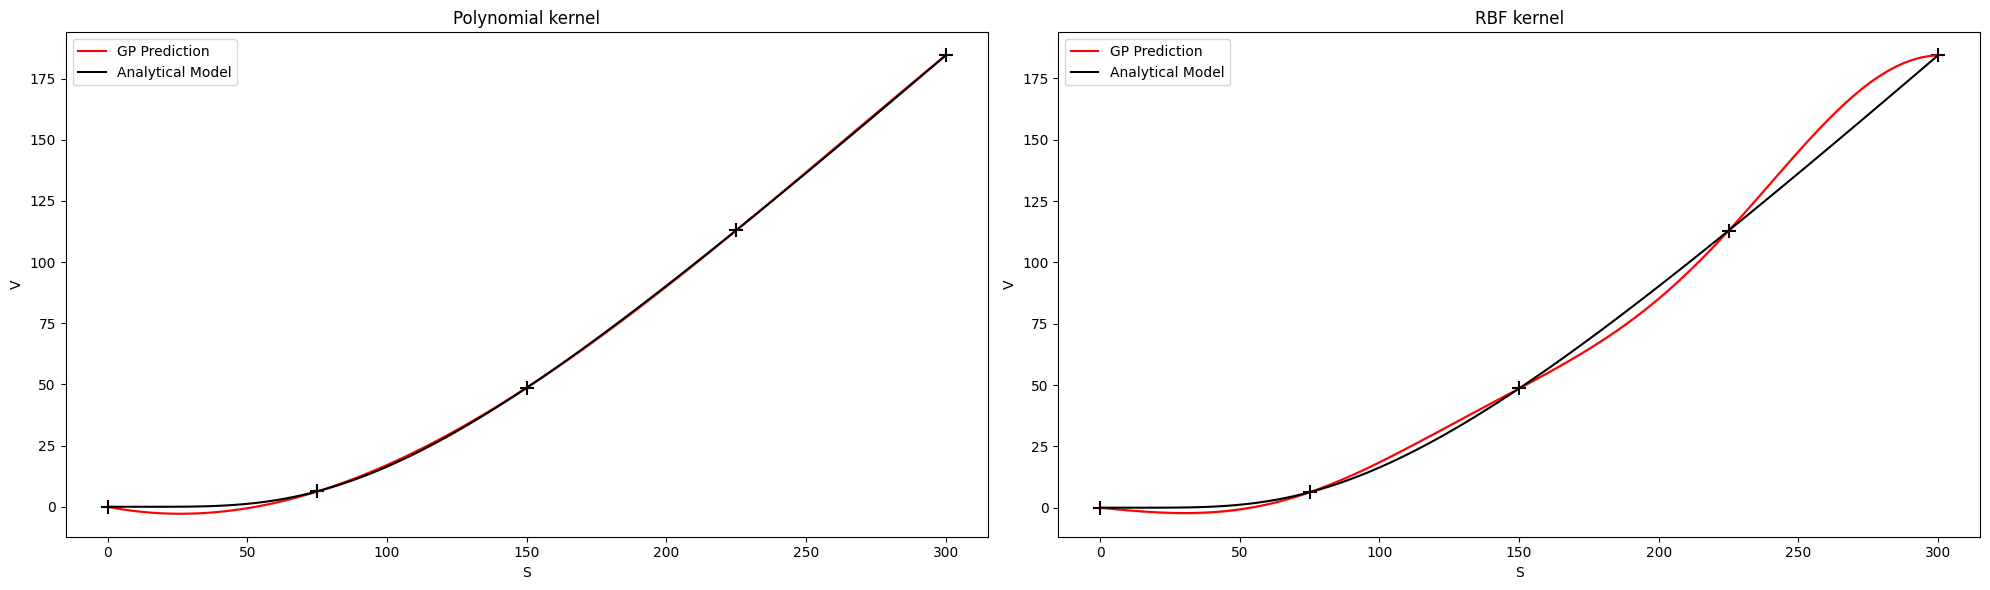

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6), facecolor='white', edgecolor='black')

# First subplot
axs[0].plot(lb + (ub - lb) * test_x_1.flatten(), y_pred_1_tf, color='red', label='GP Prediction')
axs[0].plot(lb + (ub - lb) * test_x_1.flatten(), test_y_1, color='black', label='Analytical Model')
axs[0].scatter(lb + (ub - lb) * train_x_1, train_y_1, color='black', marker='+', s=100)
axs[0].fill_between(lb + (ub - lb) * test_x_1.flatten(),
                    (y_pred_1_tf.T - 2 * sigma_1_tf).flatten(),
                    (y_pred_1_tf.T + 2 * sigma_1_tf).flatten(),
                    color='grey', alpha=0.3)
axs[0].legend(loc='best', prop={'size': 10})
# axs[0].set_xlim([KC / 2.0, 2.0 * KC])
# axs[0].set_ylim([0, 150])
axs[0].set_xlabel('S')
axs[0].set_ylabel('V')
axs[0].set_title(kernel_name + " kernel")

# Second subplot
axs[1].plot(lb + (ub - lb) * test_x_1.flatten(), y_pred_1_sp, color='red', label='GP Prediction')
axs[1].plot(lb + (ub - lb) * test_x_1.flatten(), test_y_1, color='black', label='Analytical Model')
axs[1].scatter(lb + (ub - lb) * train_x_1, train_y_1, color='black', marker='+', s=100)
axs[1].fill_between(lb + (ub - lb) * test_x_1.flatten(),
                    (y_pred_1_sp.T - 2 * sigma_1_sp).flatten(),
                    (y_pred_1_sp.T + 2 * sigma_1_sp).flatten(),
                    color='grey', alpha=0.3)
axs[1].legend(loc='best', prop={'size': 10})
# axs[1].set_xlim([KC / 2.0, 2.0 * KC])
# axs[1].set_ylim([0, 150])
axs[1].set_xlabel('S')
axs[1].set_ylabel('V')
axs[1].set_title('RBF kernel')

plt.tight_layout()
plt.show()


## 1.2 - Put

In [14]:
# Uniform sample
if not(smart_sampling):
    train_x_2 = np.array(np.linspace(0,1, training_number), dtype='float64').reshape(training_number, 1)
    train_y_2 = price_put(train_x_2.flatten()).astype('float64')
        
    test_x_2 = np.array(np.linspace(0,1, testing_number), dtype='float64').reshape(testing_number, 1)
    test_y_2 = price_put(test_x_2.flatten()).astype('float64')

# Chebychev sample
else:
    def chebyshev_nodes(n):
        return np.cos((2 * np.arange(1, n + 1) - 1) / (2 * n) * np.pi)

    train_x_2_cheb = np.array(chebyshev_nodes(training_number), dtype='float64').reshape(training_number, 1)
    arr_min = np.min(train_x_2_cheb)
    arr_max = np.max(train_x_2_cheb)
    train_x_2 = ((train_x_2_cheb - arr_min) / (arr_max - arr_min))[::-1]

    train_y_2 = price_put(train_x_2.flatten()).astype('float64')
    where_are_NaNs = np.isnan(train_y_2)
    train_y_2[where_are_NaNs] = 0
        

    test_x_2_cheb = np.array(chebyshev_nodes(testing_number), dtype='float64').reshape(testing_number, 1)
    arr_min = np.min(test_x_2_cheb)
    arr_max = np.max(test_x_2_cheb)
    test_x_2 = ((test_x_2_cheb - arr_min) / (arr_max - arr_min))[::-1]

    test_y_2 = price_put(test_x_2.flatten()).astype('float64')
    where_are_NaNs = np.isnan(test_y_2)
    test_y_2[where_are_NaNs] = 0

### GPflow

In [15]:
kernel_name = 'Polynomial'
model = gpflow.models.GPR(
    (train_x_2, train_y_2.reshape(training_number, 1)),
    kernel=gpflow.kernels.Polynomial(), # SquaredExponential(),
)

opt = gpflow.optimizers.Scipy()
_ = opt.minimize(model.training_loss, model.trainable_variables)


# model.predict_f(test_x_2)
# model.predict_y(test_x_2)

In [16]:
y_pred_2, sigma_2 = model.predict_y(test_x_2)

In [17]:
y_pred_2_tf = y_pred_2.numpy().flatten()
sigma_2_tf = sigma_2.numpy().flatten()

### Sk GP

In [18]:
sk_kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-05, 1000.0)) 
gp = gaussian_process.GaussianProcessRegressor(kernel=sk_kernel, n_restarts_optimizer=20)
gp.fit(train_x_2,train_y_2)

GaussianProcessRegressor(kernel=RBF(length_scale=1), n_restarts_optimizer=20)

In [19]:
y_pred_2_sp, sigma_2_sp = gp.predict(test_x_2, return_std=True)

### Plot

Text(0.5, 1.0, 'RBF kernel')

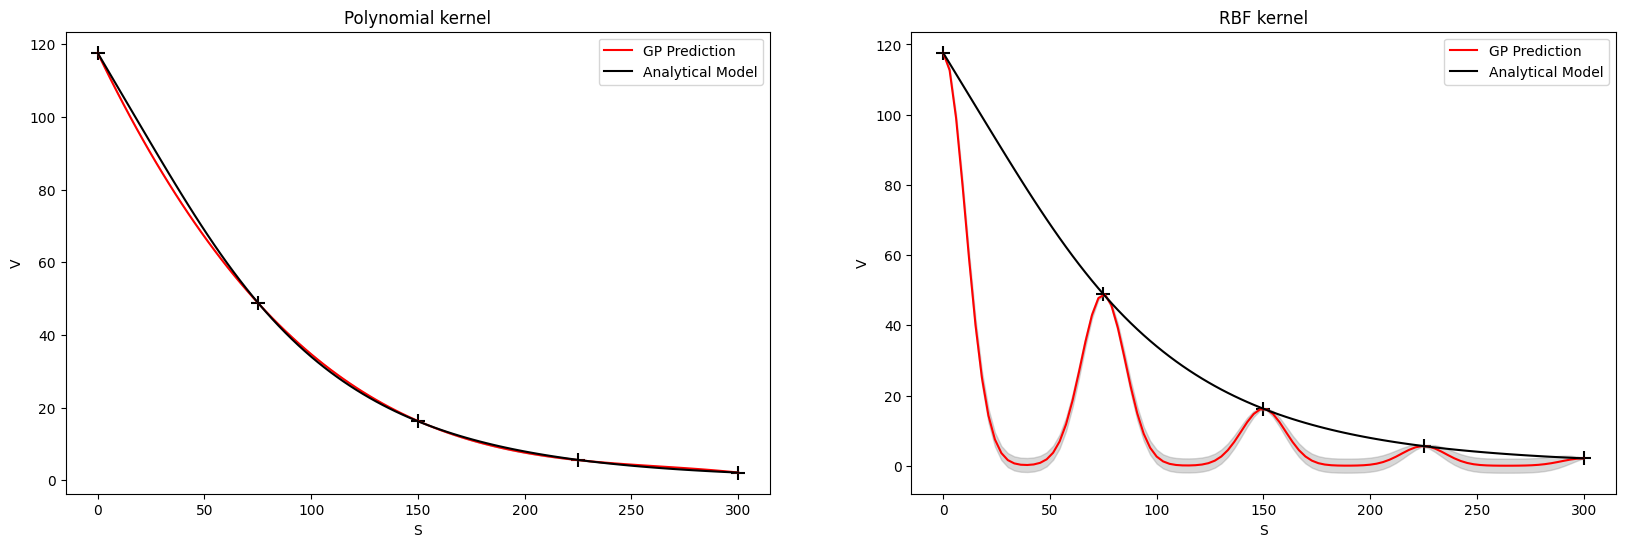

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6), facecolor='white', edgecolor='black')

# First subplot
axs[0].plot(lb+(ub-lb)*test_x_2.flatten(), y_pred_2_tf, color = 'red', label = 'GP Prediction')
axs[0].plot(lb+(ub-lb)*test_x_2.flatten(), test_y_2, color = 'black', label = 'Analytical Model')
axs[0].scatter(lb+(ub-lb)*train_x_2.flatten(), train_y_2, color = 'black', marker = '+', s = 100) 
axs[0].fill_between(lb+(ub-lb)*test_x_2.flatten(), (y_pred_2_tf.T-2*sigma_2_tf).flatten(), (y_pred_2_tf.T+2*sigma_2_tf).flatten(), color = 'grey', alpha=0.3)
axs[0].legend(loc = 'best', prop={'size':10})
# axs[0].xlim([KP/2.0,2.0*KP])
# axs[0].ylim([0,40])
axs[0].set_xlabel('S')
axs[0].set_ylabel('V')
axs[0].set_title(kernel_name + " kernel")

# Second subplot
axs[1].plot(lb+(ub-lb)*test_x_2.flatten(), y_pred_2_sp, color = 'red', label = 'GP Prediction')
axs[1].plot(lb+(ub-lb)*test_x_2.flatten(), test_y_2, color = 'black', label = 'Analytical Model')
axs[1].scatter(lb+(ub-lb)*train_x_2.flatten(), train_y_2, color = 'black', marker = '+', s = 100) 
axs[1].fill_between(lb+(ub-lb)*test_x_2.flatten(), (y_pred_2_sp.T-2*sigma_2_sp).flatten(), (y_pred_2_sp.T+2*sigma_2_sp).flatten(), color = 'grey', alpha=0.3)
axs[1].legend(loc = 'best', prop={'size':10})
# axs[1].xlim([KP/2.0,2.0*KP])
# axs[1].ylim([0,40])
axs[1].set_xlabel('S')
axs[1].set_ylabel('V')
axs[1].set_title('RBF kernel')

## 1.3 - Portfolio

Text(0.5, 1.0, 'RBF kernel')

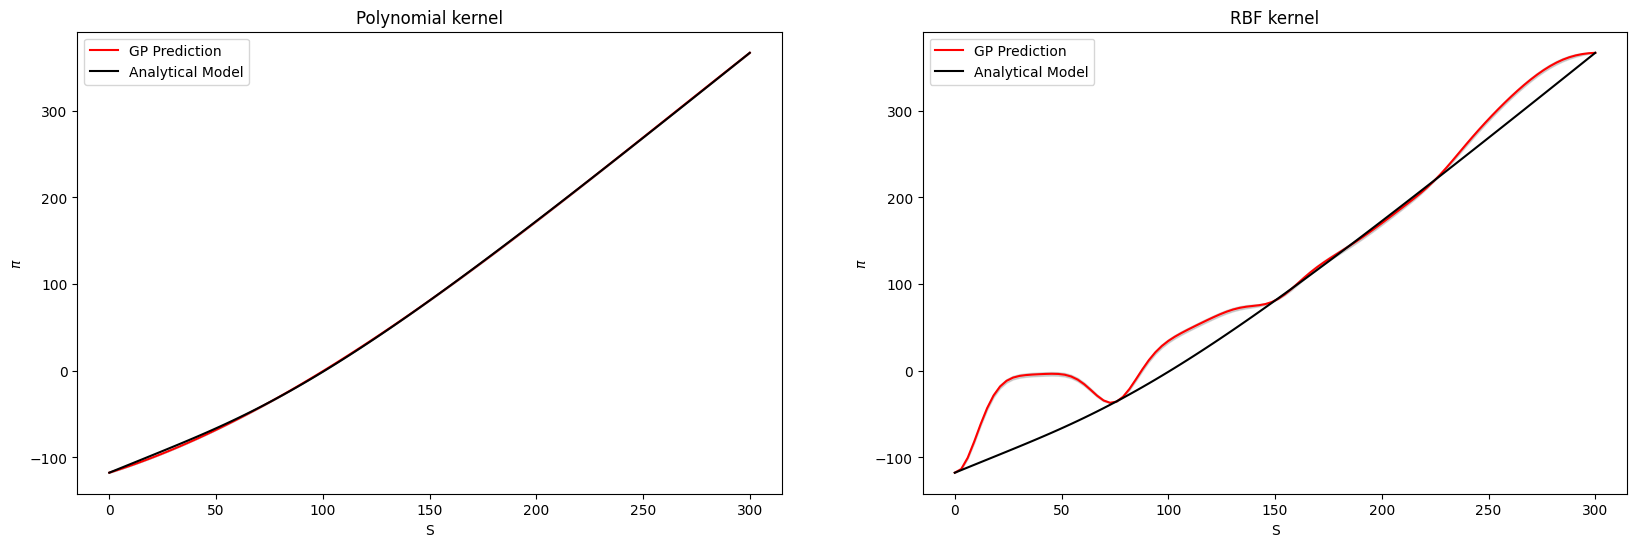

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6), facecolor='white', edgecolor='black')

# custom kern
y_pred_tf = 2.0*y_pred_1_tf - y_pred_2_tf # long 2 calls and short a put
test_y = 2.0*np.array(test_y_1) - np.array(test_y_2)
sigma_tf = np.sqrt(sigma_1_tf*sigma_1_tf + sigma_2_tf*sigma_2_tf)
axs[0].plot(lb+(ub-lb)*test_x_2.flatten(), y_pred_tf, color = 'red', label = 'GP Prediction')
axs[0].plot(lb+(ub-lb)*test_x_2.flatten(), test_y.flatten(), color = 'black', label = 'Analytical Model')
axs[0].fill_between(lb+(ub-lb)*test_x_2.flatten(), (y_pred_tf.T-2*sigma_tf).flatten(), (y_pred_tf.T+2*sigma_tf).flatten(), color = 'grey', alpha=0.3)
axs[0].legend(loc = 'best', prop={'size':10})
axs[0].set_xlabel('S')
axs[0].set_ylabel('$\pi$')
axs[0].set_title(kernel_name + " kernel")

# rbf
y_pred_sp = 2.0*y_pred_1_sp - y_pred_2_sp # long 2 calls and short a put
test_y = 2.0*np.array(test_y_1) - np.array(test_y_2)
sigma_sp = np.sqrt(sigma_1_sp*sigma_1_sp + sigma_2_sp*sigma_2_sp)
axs[1].plot(lb+(ub-lb)*test_x_2.flatten(), y_pred_sp, color = 'red', label = 'GP Prediction')
axs[1].plot(lb+(ub-lb)*test_x_2.flatten(), test_y.flatten(), color = 'black', label = 'Analytical Model')
axs[1].fill_between(lb+(ub-lb)*test_x_2.flatten(), (y_pred_sp.T-2*sigma_sp).flatten(), (y_pred_sp.T+2*sigma_sp).flatten(), color = 'grey', alpha=0.3)
axs[1].legend(loc = 'best', prop={'size':10})
axs[1].set_xlabel('S')
axs[1].set_ylabel('$\pi$')
axs[1].set_title('RBF kernel')

# 2 - GP Greeks

In [22]:
lb = 0
ub = 300
training_number = 100
testing_number = 50
sigma_n = 1e-8 # additive noise in GP

In [23]:
option = option_f(MarketEnvironment(sigma=sigma), option_type="call", K=KC, T=time2mat(T))

price = lambda x,y: option.price(lb+(ub-lb)*x, T, True, sigma=y)
delta = lambda x,y: option.delta(lb+(ub-lb)*x, T, True, sigma=y)
vega = lambda x,y: S0*option.vega(lb+(ub-lb)*x, T, True, sigma=y)

price_t = lambda x,y: option.price(lb+(ub-lb)*x, y, True)
theta = lambda x,y: option.theta(lb+(ub-lb)*x, y, True)

Initializing the MarketEnvironment!
Initializing the EuropeanOption!


## 2.1 - Delta

In [24]:
# Uniform sample
if not(smart_sampling):
    x_train = np.array(np.linspace(0.01,1.2, training_number), dtype='float64').reshape(training_number, 1)
    x_test = np.array(np.linspace(0.01,1.0, testing_number), dtype='float64').reshape(testing_number, 1)
    y_train = price(x_train.flatten(), sigma)

# Chebychev sample
else:
    def chebyshev_nodes(n):
        return np.cos((2 * np.arange(1, n + 1) - 1) / (2 * n) * np.pi)

    train_x_cheb = np.array(chebyshev_nodes(training_number), dtype='float64').reshape(training_number, 1)
    arr_min = np.min(train_x_cheb)
    arr_max = np.max(train_x_cheb)
    x_train = ((train_x_cheb - arr_min) / (arr_max - arr_min))[::-1]

    y_train = price_call(x_train.flatten()).astype('float64')
    where_are_NaNs = np.isnan(y_train)
    y_train[where_are_NaNs] = 0
        

    test_x_cheb = np.array(chebyshev_nodes(testing_number), dtype='float64').reshape(testing_number, 1)
    arr_min = np.min(test_x_cheb)
    arr_max = np.max(test_x_cheb)
    x_test = ((test_x_cheb - arr_min) / (arr_max - arr_min))[::-1]

In [25]:
y_test = price_call(x_test.flatten()).astype('float64')
where_are_NaNs = np.isnan(y_test)
y_test[where_are_NaNs] = 0

### GPflow

In [26]:
""" Possible kernels for this part:
    Cosine,
    Exponential,
    Matern12,
    Matern32,
    Matern52,
    RationalQuadratic,
    SquaredExponential
"""

kernel_name = 'RationalQuadratic'
model = gpflow.models.GPR(
    (x_train, y_train.reshape(training_number, 1)),
    kernel=gpflow.kernels.RationalQuadratic(), # SquaredExponential(),
)

opt = gpflow.optimizers.Scipy()
_ = opt.minimize(model.training_loss, model.trainable_variables)

In [27]:
y_pred, sigma_hat = model.predict_f(x_test)

In [28]:
y_pred_tf = y_pred.numpy().flatten()
sigma_hat_tf = sigma_hat.numpy().flatten()

In [29]:
l = model.kernel.lengthscales
rbf = gpflow.kernels.Exponential(lengthscales=l)
# gaussian_process.kernels.RBF(length_scale=l)

Kernel = rbf(x_train, x_train)
K_y = Kernel + np.eye(training_number) * sigma_n
L = sp.linalg.cho_factor(K_y)
alpha_p = sp.linalg.cho_solve(L, y_train) # np.transpose(L)

k_s = rbf(x_test, x_train)
k_s_prime = (x_train.T - x_test) * k_s / l**2
f_prime_tf = np.dot(k_s_prime, alpha_p)/(ub-lb)

### Sk GP

In [30]:
sk_kernel = RBF(length_scale=1.0, length_scale_bounds=(0.01, 10000.0)) #+ WhiteKernel(noise_level = 1e-12) #100000.0
gp = gaussian_process.GaussianProcessRegressor(kernel=sk_kernel, n_restarts_optimizer=20)
gp.fit(x_train,y_train)
y_pred, sigma_hat = gp.predict(x_test, return_std=True)
    
l = gp.kernel_.length_scale
rbf= gaussian_process.kernels.RBF(length_scale=l)

Kernel= rbf(x_train, x_train)
K_y = Kernel + np.eye(training_number) * sigma_n
L = sp.linalg.cho_factor(K_y)
alpha_p = sp.linalg.cho_solve(L, y_train) # np.transpose(L)

k_s = rbf(x_test, x_train)
k_s_prime = (x_train.T - x_test) * k_s / l**2
f_prime_sp = np.dot(k_s_prime, alpha_p)/(ub-lb)

### Plot

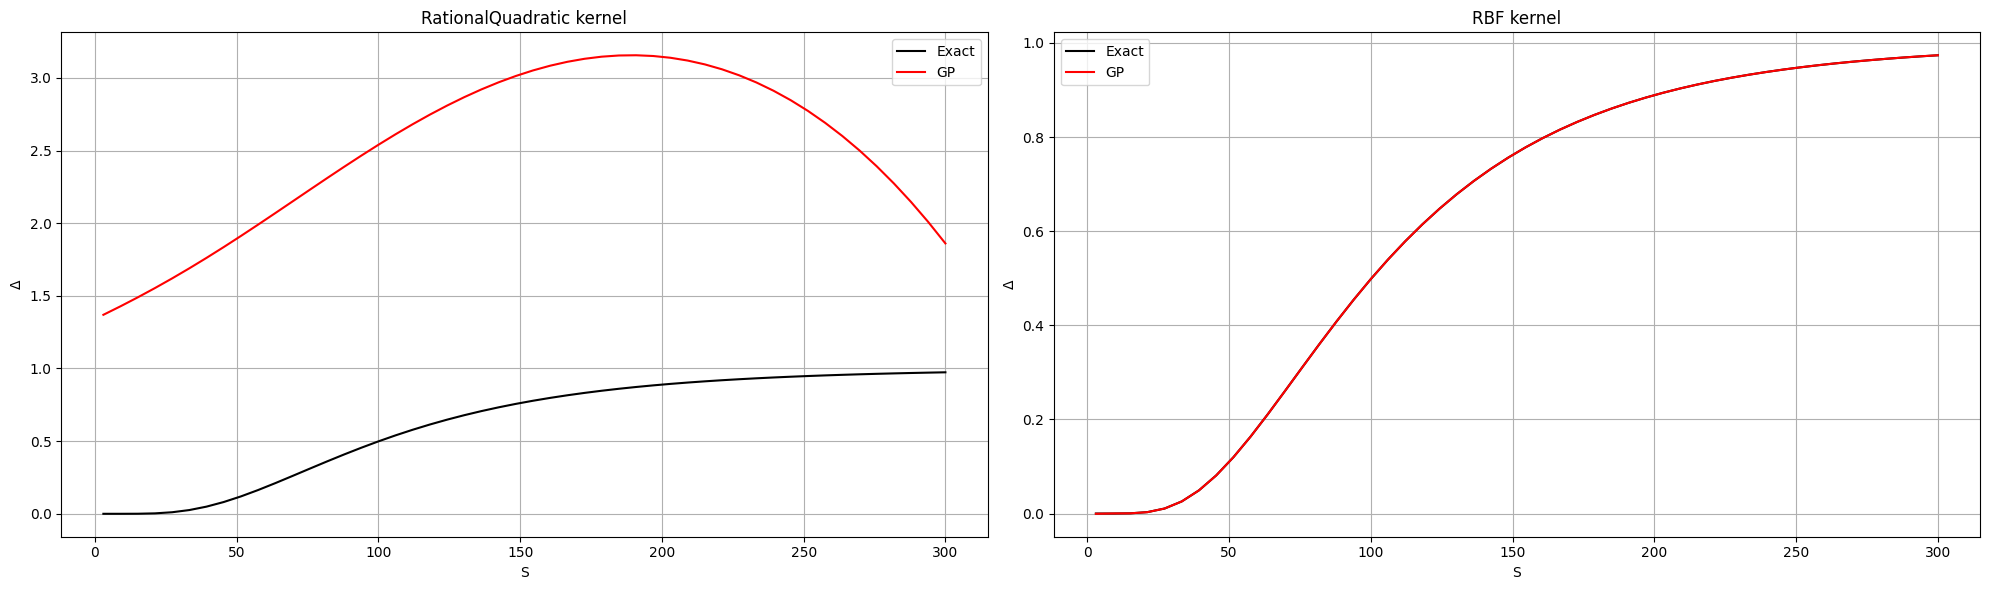

In [31]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6), facecolor='white', edgecolor='black')

# First subplot
axs[0].plot(lb+(ub-lb)*x_test, delta(x_test.flatten(), sigma), color = 'black', label = 'Exact')
axs[0].plot(lb+(ub-lb)*x_test, f_prime_tf, color = 'red', label = 'GP')
axs[0].grid(True)
axs[0].legend(loc = 'best', prop={'size':10})
axs[0].set_xlabel('S')
axs[0].set_ylabel('$\Delta$')
axs[0].set_title(kernel_name + " kernel")

# Second subplot
axs[1].plot(lb+(ub-lb)*x_test, delta(x_test.flatten(), sigma), color = 'black', label = 'Exact')
axs[1].plot(lb+(ub-lb)*x_test, f_prime_sp, color = 'red', label = 'GP')
axs[1].grid(True)
axs[1].legend(loc = 'best', prop={'size':10})
axs[1].set_xlabel('S')
axs[1].set_ylabel('$\Delta$')
axs[1].set_title('RBF kernel')

plt.tight_layout()
plt.show()


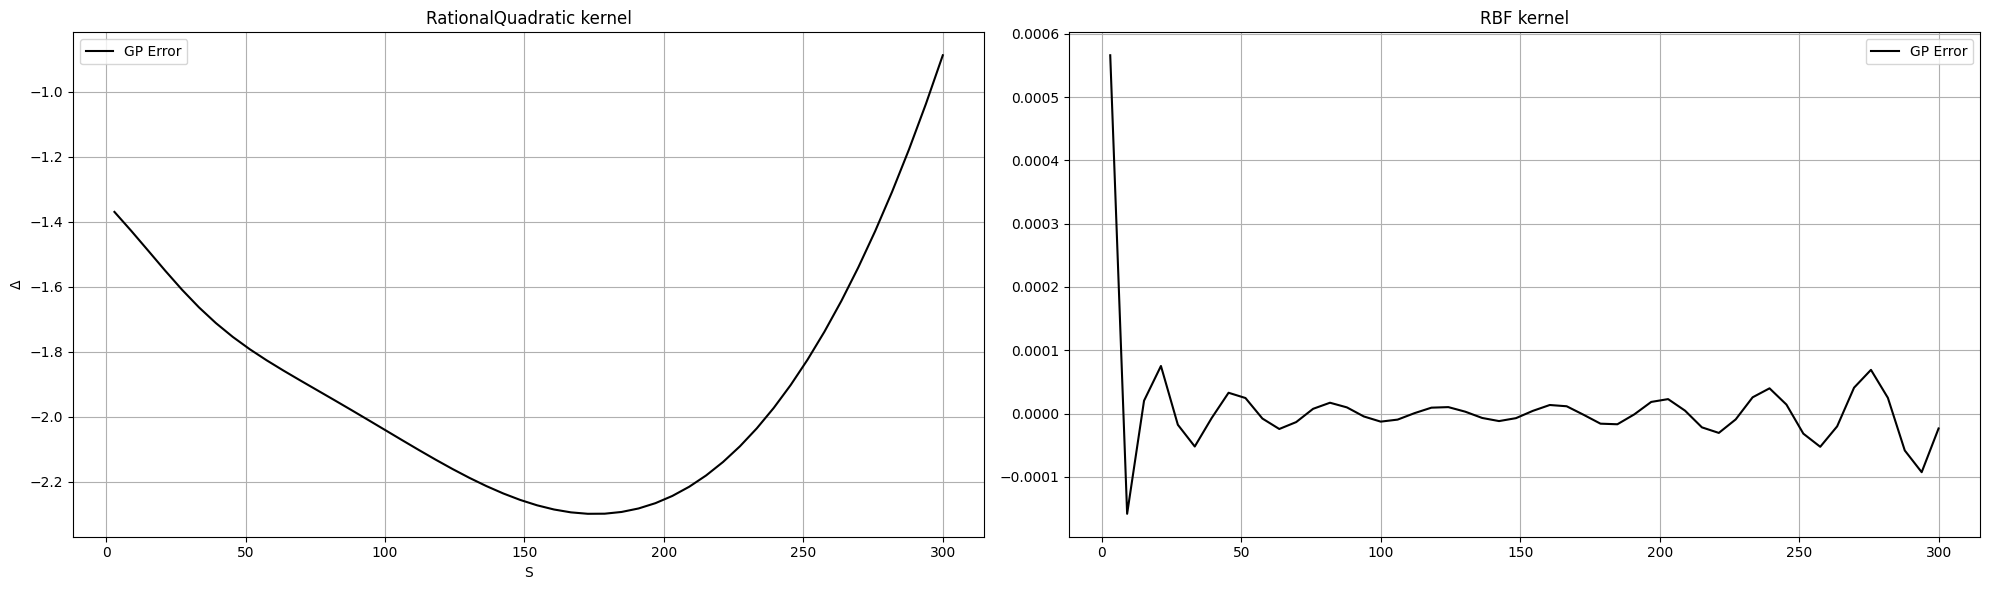

In [32]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6), facecolor='white', edgecolor='black')

# First subplot
axs[0].plot(lb+(ub-lb)*x_test, delta(x_test.flatten(),sigma) - f_prime_tf.flatten(), color = 'black', label = 'GP Error')
axs[0].grid(True)
axs[0].legend(loc = 'best', prop={'size':10})
axs[0].set_xlabel('S')
axs[0].set_ylabel('$\Delta$')
axs[0].set_title(kernel_name + " kernel")

# Second subplot
plt.plot(lb+(ub-lb)*x_test, delta(x_test.flatten(),sigma) - f_prime_sp.flatten(), color = 'black', label = 'GP Error')
axs[1].grid(True)
axs[1].legend(loc = 'best', prop={'size':10})
axs[0].set_xlabel('S')
axs[0].set_ylabel('$\Delta$')
axs[1].set_title('RBF kernel')

plt.tight_layout()
plt.show()


## 2.2 - Vega

In [33]:
# Uniform sample
if not(smart_sampling):
    x_train = np.array(np.linspace(0.01,1.2, training_number), dtype='float64').reshape(training_number, 1)
    x_test = np.array(np.linspace(0.01,1.0, testing_number), dtype='float64').reshape(testing_number, 1)
    y_train = price((S0-lb)/(ub-lb), x_train.flatten()).reshape(training_number, 1)

# Chebychev sample
else:
    def chebyshev_nodes(n):
        return np.cos((2 * np.arange(1, n + 1) - 1) / (2 * n) * np.pi)

    train_x_cheb = np.array(chebyshev_nodes(training_number), dtype='float64').reshape(training_number, 1)
    arr_min = np.min(train_x_cheb)
    arr_max = np.max(train_x_cheb)
    x_train = ((train_x_cheb - arr_min) / (arr_max - arr_min))[::-1]

    y_train = price_call(x_train.flatten()).astype('float64')
    where_are_NaNs = np.isnan(y_train)
    y_train[where_are_NaNs] = 0
        

    test_x_cheb = np.array(chebyshev_nodes(testing_number), dtype='float64').reshape(testing_number, 1)
    arr_min = np.min(test_x_cheb)
    arr_max = np.max(test_x_cheb)
    x_test = ((test_x_cheb - arr_min) / (arr_max - arr_min))[::-1]

### GPflow

In [34]:
"""
    Cosine,
    Exponential,
    Matern12,
    Matern32,
    Matern52,
    RationalQuadratic,
    SquaredExponential
"""

kernel_name = 'Exponential'
model = gpflow.models.GPR(
    (x_train, y_train.reshape(training_number, 1)),
    kernel=gpflow.kernels.Exponential(),
)

opt = gpflow.optimizers.Scipy()
_ = opt.minimize(model.training_loss, model.trainable_variables)


# model.predict_f(test_x_1)
# model.predict_y(test_x_1)

In [35]:
y_pred, sigma_hat = model.predict_y(x_test)

In [36]:
y_pred_tf = y_pred.numpy().flatten()
sigma_hat_tf = sigma_hat.numpy().flatten()

In [37]:
l = model.kernel.lengthscales
rbf = gpflow.kernels.Exponential(lengthscales=l)
# gaussian_process.kernels.RBF(length_scale=l)

Kernel = rbf(x_train, x_train)
K_y = Kernel + np.eye(training_number) * sigma_n
L = sp.linalg.cho_factor(K_y)
alpha_p = sp.linalg.cho_solve(L, y_train) # np.transpose(L)

k_s = rbf(x_test, x_train)
k_s_prime = (x_train.T - x_test) * k_s / l**2
f_prime_tf = np.dot(k_s_prime, alpha_p)/(ub-lb)

### Sk GP

In [38]:
sk_kernel = RBF(length_scale=1.0, length_scale_bounds=(0.01, 10000.0)) #+ WhiteKernel(noise_level = 1e-12) #100000.0
gp = gaussian_process.GaussianProcessRegressor(kernel=sk_kernel, n_restarts_optimizer=20)
gp.fit(x_train,y_train)
y_pred, sigma_hat = gp.predict(x_test, return_std=True)
    
l = gp.kernel_.length_scale
rbf= gaussian_process.kernels.RBF(length_scale=l)
 
Kernel= rbf(x_train, x_train)
K_y = Kernel + np.eye(training_number) * sigma_n
L = sp.linalg.cho_factor(K_y)
alpha_p = sp.linalg.cho_solve(L, y_train) #np.transpose(L)
    
k_s = rbf(x_test, x_train)

k_s_prime = np.zeros([len(x_test), len(x_train)])
for i in range(len(x_test)):
    for j in range(len(x_train)):
        k_s_prime[i,j]=(1.0/l**2)*(x_train[j]-x_test[i])*k_s[i,j]
        
f_prime_sp = np.dot(k_s_prime, alpha_p)

### Plot

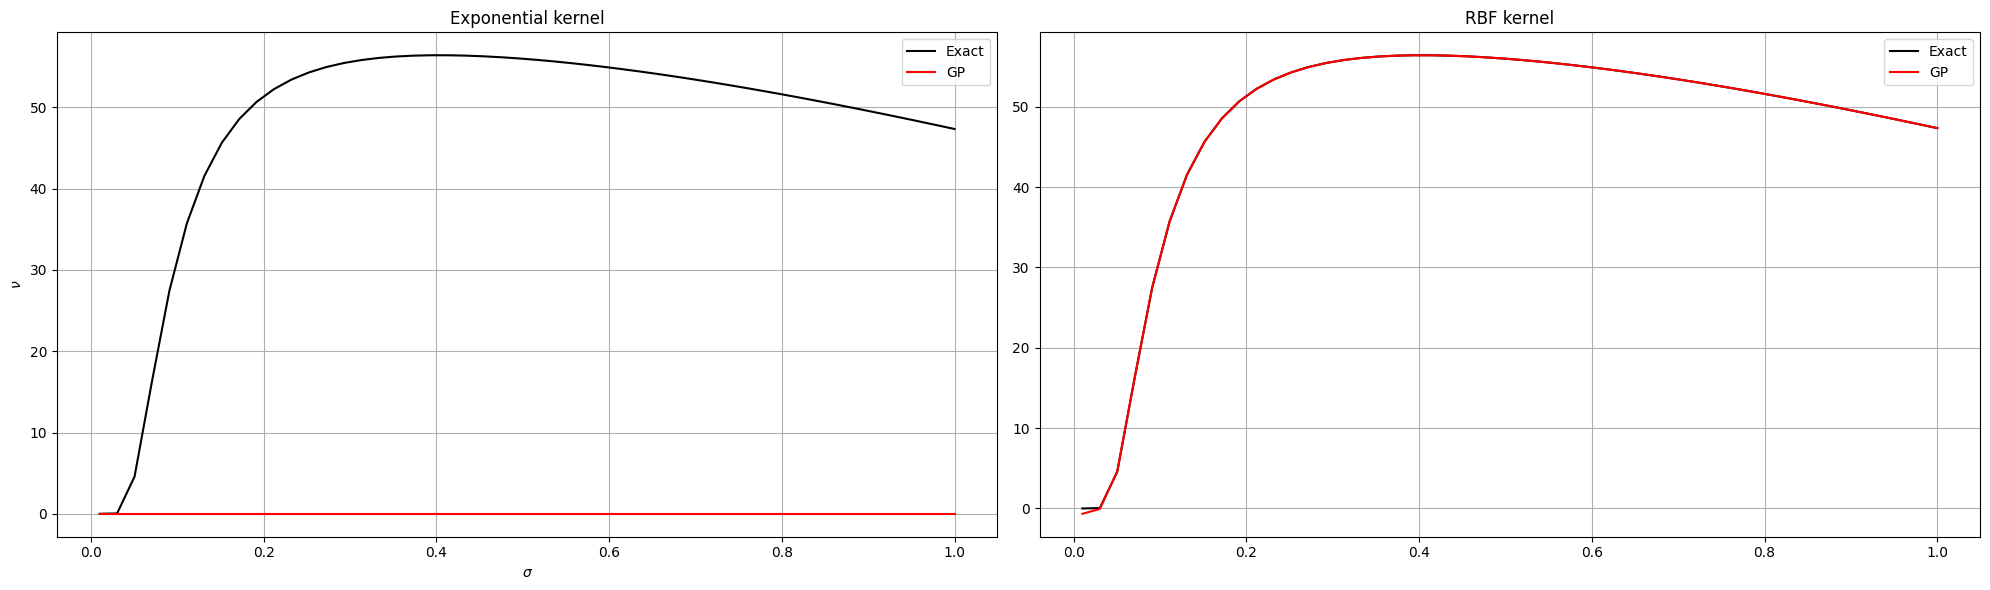

In [39]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6), facecolor='white', edgecolor='black')

# First subplot
axs[0].plot(x_test, vega((S0-lb)/(ub-lb), x_test.flatten()), color = 'black', label = 'Exact')
axs[0].plot(x_test, f_prime_tf, color = 'red', label = 'GP')
axs[0].grid(True)
axs[0].legend(loc = 'best', prop={'size':10})
axs[0].set_xlabel('$\\sigma$')
axs[0].set_ylabel('$\\nu$')
axs[0].set_title(kernel_name + " kernel")

# Second subplot
axs[1].plot(x_test, vega((S0-lb)/(ub-lb), x_test.flatten()), color = 'black', label = 'Exact')
axs[1].plot(x_test, f_prime_sp, color = 'red', label = 'GP')
axs[1].grid(True)
axs[1].legend(loc = 'best', prop={'size':10})
axs[0].set_xlabel('$\\sigma$')
axs[0].set_ylabel('$\\nu$')
axs[1].set_title('RBF kernel')

plt.tight_layout()
plt.show()


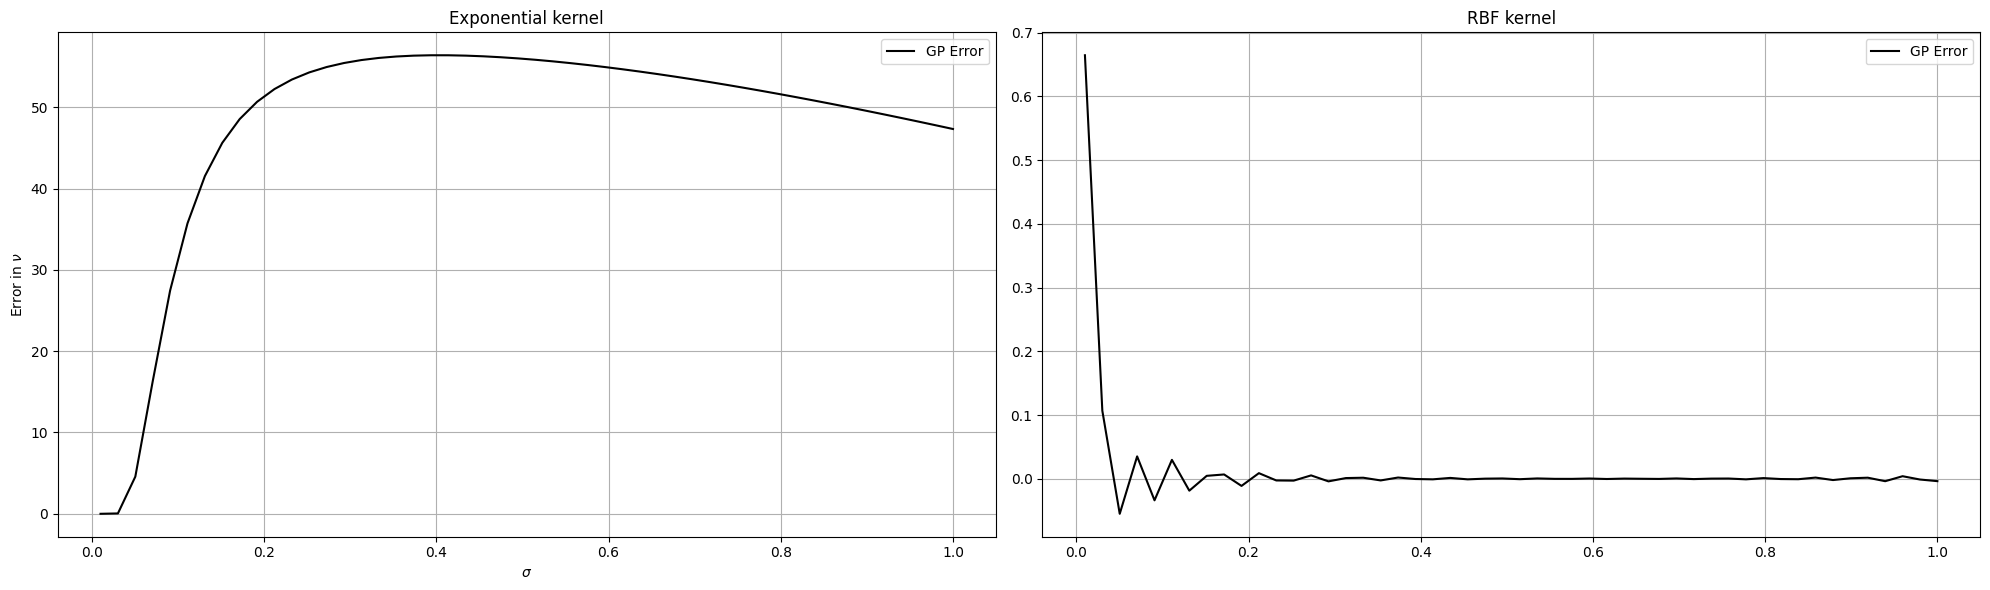

In [40]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6), facecolor='white', edgecolor='black')

# First subplot
axs[0].plot(x_test, vega((S0-lb)/(ub-lb), x_test.flatten())-f_prime_tf.flatten(), color = 'black', label = 'GP Error')
axs[0].grid(True)
axs[0].legend(loc = 'best', prop={'size':10})
axs[0].set_xlabel('$\\sigma$')
axs[0].set_ylabel('Error in $\\nu$')
axs[0].set_title(kernel_name + " kernel")

# Second subplot
plt.plot(x_test, vega((S0-lb)/(ub-lb), x_test.flatten())-f_prime_sp.flatten(), color = 'black', label = 'GP Error')
axs[1].grid(True)
axs[1].legend(loc = 'best', prop={'size':10})
axs[0].set_xlabel('$\\sigma$')
axs[0].set_ylabel('Error in $\\nu$')
axs[1].set_title('RBF kernel')

plt.tight_layout()
plt.show()


## 2.3 - Theta ---- to check

In [41]:
x_train = np.array(np.linspace(0.01,1.2, training_number), dtype='float32').reshape(training_number, 1)
x_test = np.array(np.linspace(0.01,1.0, testing_number), dtype='float32').reshape(testing_number, 1)

y_train = price_t((S0-lb)/(ub-lb), np.array(x_train.flatten(), dtype='float')).reshape(training_number, 1)

sk_kernel = RBF(length_scale=1.0, length_scale_bounds=(0.01, 10000.0)) #+ WhiteKernel(noise_level = 1e-12) #100000.0
gp = gaussian_process.GaussianProcessRegressor(kernel=sk_kernel, n_restarts_optimizer=20)
gp.fit(x_train,y_train)
y_pred, sigma_hat = gp.predict(x_test, return_std=True)

l = gp.kernel_.length_scale
rbf= gaussian_process.kernels.RBF(length_scale=l)

Kernel= rbf(x_train, x_train)
K_y = Kernel + np.eye(training_number) * sigma_n
L = sp.linalg.cho_factor(K_y)
alpha_p = sp.linalg.cho_solve(L, y_train) #np.transpose(L)

k_s = rbf(x_test, x_train)

k_s_prime = np.zeros([len(x_test), len(x_train)])
for i in range(len(x_test)):
    for j in range(len(x_train)):
        k_s_prime[i,j]=(1.0/l**2)*(x_train[j]-x_test[i])*k_s[i,j]

f_prime = np.dot(k_s_prime, alpha_p)

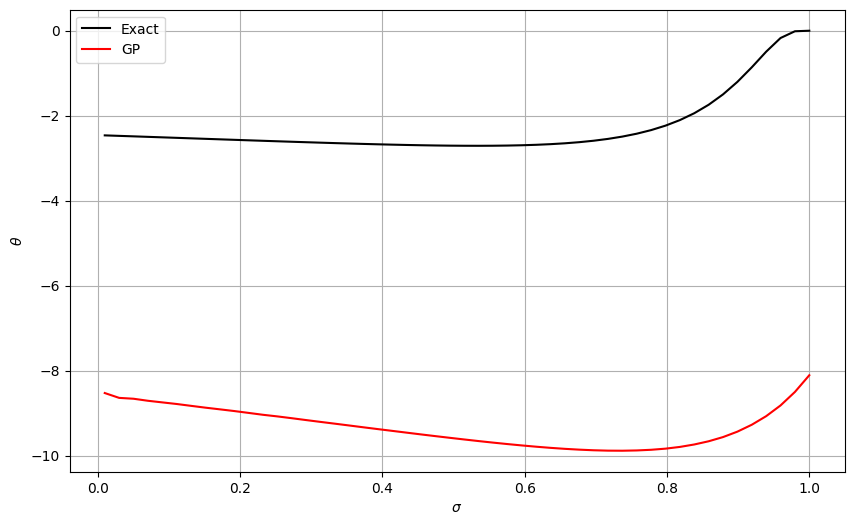

In [42]:
plt.figure(figsize = (10,6),facecolor='white', edgecolor='black')
plt.plot(x_test, 100*theta((S0-lb)/(ub-lb), np.array(x_test.flatten(), dtype='float')), color = 'black', label = 'Exact') # pourquoi *100 ?
plt.plot(x_test, f_prime, color = 'red', label = 'GP')
plt.grid(True)
plt.xlabel('$\\sigma$')
plt.ylabel('$\\theta$')
plt.legend(loc = 'best', prop={'size':10})

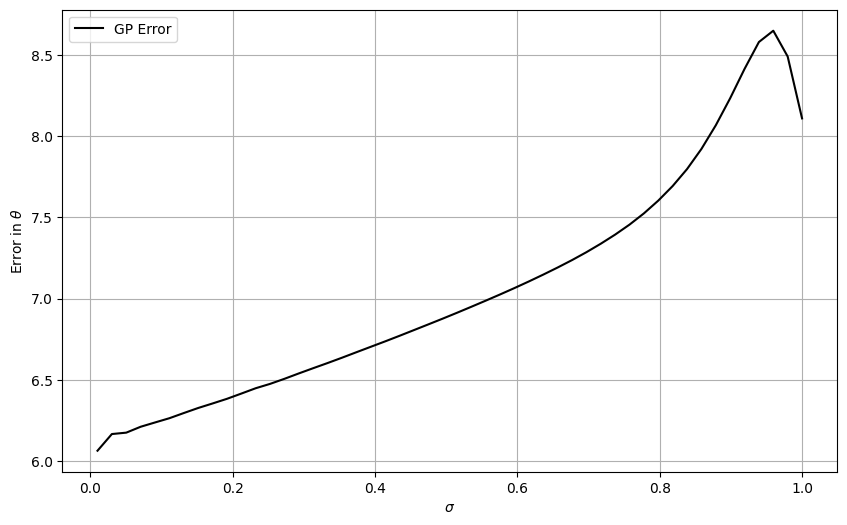

In [43]:
plt.figure(figsize = (10,6),facecolor='white', edgecolor='black')
plt.plot(x_test, 100*theta((S0-lb)/(ub-lb), np.array(x_test.flatten(), dtype='float'))-f_prime.flatten(), color = 'black', label = 'GP Error')
plt.grid(True)
plt.xlabel('$\\sigma$')
plt.ylabel('Error in $\\theta$')
plt.legend(loc = 'best', prop={'size':10})

# 3 - GP CVA

In [44]:
# specify the portfolio
KC = 110    # Call strike
KP = 90     # Put strike
lb = 0.01
ub = 400
r  = 0
sigma = 0.3
nt = 11
T = 2.0
S0 = 100
timegrid = np.array(np.linspace(0.0,T,nt), dtype='float32').reshape(nt, 1)

## 2.1 - BS CVA

In [45]:
mkt = MarketEnvironment(sigma=sigma)
option_call = option_f(mkt, option_type="call", K=KC, T=time2mat(T))
option_put = option_f(mkt, option_type="put", K=KP, T=time2mat(T))

portfolio = {}
portfolio['call']={}
portfolio['put']={}

portfolio['call']['price']= lambda x,y: option_call.price(lb+(ub-lb)*x, y, True)
portfolio['put']['price']= lambda x,y: option_put.price(lb+(ub-lb)*x, y, True)
portfolio['call']['weight']=2.0
portfolio['put']['weight']=-1.0


# prepare training and test data
training_number= 100
testing_number = 50

Initializing the MarketEnvironment!
Initializing the EuropeanOption!
Initializing the EuropeanOption!


In [46]:
# Uniform sample
if not(smart_sampling):
    x_train = np.array(np.linspace(0.0,1.0, training_number), dtype='float32').reshape(training_number, 1)
    x_test = np.array(np.linspace(0.0,1.0, testing_number), dtype='float32').reshape(testing_number, 1)

# Chebychev sample
else:
    x_train = np.array(chebyshev_nodes(training_number), dtype='float32').reshape(training_number, 1)
    arr_min = np.min(x_train)
    arr_max = np.max(x_train)
    x_train = ((train_x_1_cheb - arr_min) / (arr_max - arr_min))[::-1]
    x_test = np.array(chebyshev_nodes(testing_number), dtype='float32').reshape(testing_number, 1)
    arr_min = np.min(x_test)
    arr_max = np.max(x_test)
    x_test = ((test_x_1_cheb - arr_min) / (arr_max - arr_min))[::-1]

In [ ]:
def trainGPs(x_train, f, timegrid):

    gps = []
    i = 0
    # f(x_train.flatten(), time.flatten())
    for time in timegrid:
        y_train = f(x_train.flatten(), float(time))
        sk_kernel = RBF(length_scale=1.0, length_scale_bounds=(0.01, 100.0))  #100000.0
        gp = gaussian_process.GaussianProcessRegressor(kernel=sk_kernel, n_restarts_optimizer=20)
        gp.fit(x_train,y_train)
        gps.append(gp)
        i += 1
    return gps   

def predictGPs(x_test, f, gps, timegrid):
    
    preds = []
    stds = []
    y_tests = []
    i = 0
    for time in timegrid:
        y_test = f(x_test.flatten(), float(time))
        y_tests.append(y_test)
        
        # Find optimal model hyperparameters
        # Set into eval mode
        pred, std = gps[i].predict(x_test,return_std=True)
        preds.append(pred)
        stds.append(std)
        i+=1
    return y_tests, preds, stds 

In [50]:
# train and predict over portfolio
for key in portfolio.keys():
    portfolio[key]['GPs'] = trainGPs(x_train, portfolio[key]['price'], timegrid)
    portfolio[key]['y_tests'], portfolio[key]['preds'], portfolio[key]['sigmas'] = predictGPs(x_test, portfolio[key]['price'], portfolio[key]['GPs'], timegrid)

In [51]:
def CVA_simulation(sim_params, model_params, def_model):
    
    n_sim_dt = sim_params['n_sim_dt'] # number of Euler stpes
    M        = sim_params['M']        # number of paths
    nt       = sim_params['nt']       # number of exposure dates
    timegrid = sim_params['timegrid'] # time grid of exposure dates
    
    r        = model_params['r']
    sigma    = model_params['sigma']
    T        = model_params['T']
    t0       = model_params['t0'] 
    S0       = model_params['S0'] 
    
    gamma_0  = def_model['gamma_0']
    gamma_1  = def_model['gamma_1']
    
    
    stride = n_sim_dt/(nt-1)
    idx = np.arange(0,n_sim_dt+1,stride, dtype=int)
    
    pi = {}
    pi['tilde'] = np.array([0.0]*(nt-1)*M, dtype='float32').reshape((nt-1), M)     # GP portfolio value
    pi['exact'] = np.array([0.0]*(nt-1)*M, dtype='float32').reshape((nt-1), M)     # BS portfolio value
    pi['tilde_var'] = np.array([0.0]*(nt-1)*M, dtype='float32').reshape((nt-1), M) # GP portfolio variance
    gamma = np.array([0.0]*(nt-1)*M, dtype='float32').reshape((nt-1), M)           # hazard rates
    dPD = np.array([0.0]*(nt-1)*M, dtype='float32').reshape((nt-1), M)             # default probabilities
    
    #simulate underlying GBM dynamics using Euler
    S = gbm(S0, r, sigma, T-t0, n_sim_dt, M)
    
    if (def_model['calibrate']):
        x  = np.exp(S0/S)**gamma_1
        # default probability (assumed to be estimated from credit spread)
        dt = timegrid[1]-timegrid[0] 
        f  = lambda y: np.abs(np.mean(np.prod(x**(-y*dt), axis=0)) - def_model['p']) 
        res = sp.optimize.basinhopping(f, 0.1, niter=10)
        i = 1   
        while (abs(res.fun) >1e-3):   
          res = sp.optimize.basinhopping(f, 0.1, niter=100*i)
          i *= 2
        gamma_0= res.x[0]
        print("calibration:", gamma_0, gamma_1, f(gamma_0), res.fun)  
    
    
    for m in range(M):  
      i = 1 
      exp_factor=1
        
      for time in timegrid[1:]:
        dt = timegrid[i]-timegrid[i-1]
        
        S_= S[idx[i],m] # simulated S
        # avoid simulated S breaching boundaries of domain
        if (S_<lb):
            mins=S_
            S_=lb
        if (S_>ub):
            S_=ub
            maxs=S_
    
        pred_= 0
        v_ = 0
        var_ =0 
    
        for key in portfolio.keys():
           pred, std = portfolio[key]['GPs'][i].predict(np.array([(S_-lb)/(ub-lb)]).reshape(1,-1),return_std=True) 
           pred_ += portfolio[key]['weight']*pred
           var_ += (portfolio[key]['weight']*std)**2 
           
           if key=='call':
              v_ += portfolio[key]['weight']*option_call.price(float(S_), float(time), True) # bsformula(1, S_, KC, r, time, sigma, 0)[0] # -------------------------- 
           else:
              v_ += portfolio[key]['weight']*option_put.price(float(S_), float(time), True) # bsformula(-1, S_, KP, r, time, sigma, 0)[0] # --------------------------
        pi['tilde'][i-1,m] = np.maximum(pred_,0)
        pi['exact'][i-1,m] = np.maximum(v_,0)
        pi['tilde_var'][i-1,m] =var_ 
          
        # default intensity model
        gamma[i-1,m] = gamma_0*(S0/S_)**gamma_1    
        
        # compute default probabilities  
        exp_factor*=np.exp(-dt*gamma[i-1,m])    
        dPD[i-1,m]= gamma[i-1,m]*exp_factor
        
        i += 1
    # compute CVA
    i = 0
    CVA ={}
    CVA['tilde'] = 0
    CVA['exact'] = 0
    CVA['tilde_up'] = 0
    CVA['tilde_down'] = 0
   
    for time in timegrid[1:]:
        dt = timegrid[i+1]-timegrid[i]
        mu_tilde = np.mean(dPD[i,:]*pi['tilde'][i,:])*np.exp(-r*(time-t0))*dt
        CVA['tilde'] += mu_tilde
        std_err_MC = np.std(dPD[i,:]*pi['tilde'][i,:])*np.exp(-r*(time-t0))*dt/np.sqrt(M)
        CVA['tilde_up'] += mu_tilde + 2.0*std_err_MC
        CVA['tilde_down'] += mu_tilde - 2.0*std_err_MC
        CVA['exact'] += np.mean(dPD[i,:]*pi['exact'][i,:])*np.exp(-r*(time-t0))*dt
        i+=1
    CVA['tilde'] *= (1-def_model['recovery'])
    CVA['tilde_up'] *= (1-def_model['recovery'])
    CVA['tilde_down'] *= (1-def_model['recovery'])
    CVA['exact'] *= (1-def_model['recovery'])
        
    return(CVA, pi)

In [52]:
sim_params = {}
model_params = {}
def_model = {}
  
model_params['r'] = r        # risk-free rate
model_params['sigma'] = sigma  # implied volatility
model_params['T'] = T        # Time to maturity 
model_params['t0'] = 0
model_params['S0'] = S0     # Underlying spot
     
# parameters to the default intensity model    
def_model['gamma_0'] = 0.01
def_model['gamma_1'] = 1.2
def_model['calibrate'] = False    
def_model['recovery'] = 0.4

sim_params['n_sim_dt'] = 100 # number of Euler stpes
sim_params['M']  = 1000      # number of paths
sim_params['nt'] = nt        # number of exposure dates

sim_params['timegrid']= timegrid # time grid of exposure dates

In [53]:
option_call.price(105.381, [0.2], True)

array([4.13930693])

In [54]:
# train and predict over portfolio
for key in portfolio.keys():
    portfolio[key]['GPs'] = trainGPs(x_train, portfolio[key]['price'], timegrid)
    portfolio[key]['y_tests'], portfolio[key]['preds'], portfolio[key]['sigmas'] = predictGPs(x_test, portfolio[key]['price'], portfolio[key]['GPs'], timegrid)

CVA_0, pi = CVA_simulation(sim_params, model_params, def_model)

In [55]:
CVA_0

{'tilde': array([0.21270895], dtype=float32),
 'exact': array([0.2127089], dtype=float32),
 'tilde_up': array([0.22851678]),
 'tilde_down': array([0.19690109])}

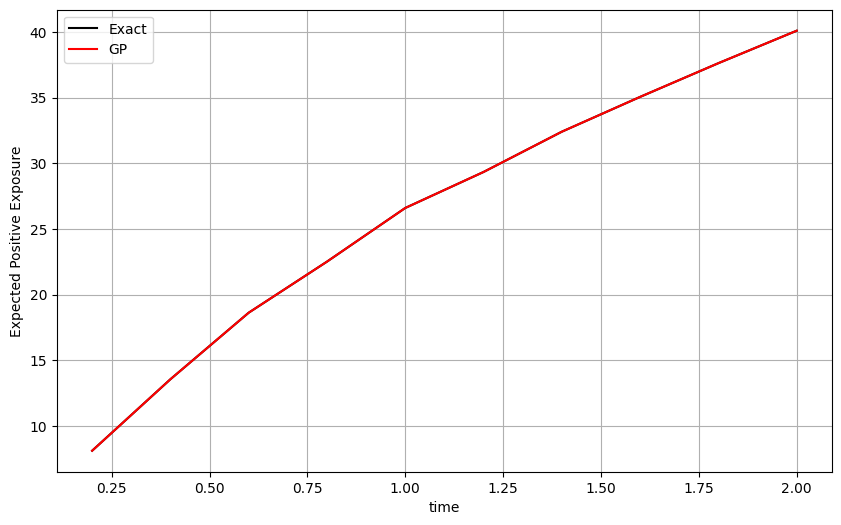

In [56]:
# Error plot
up = np.mean(pi['tilde'], axis=1) -np.mean(pi['exact'], axis=1)+2.0*np.sqrt(np.mean(pi['tilde_var'], axis=1))   # 95% confident interval 
down = np.mean(pi['tilde'], axis=1) -np.mean(pi['exact'], axis=1)- 2.0*np.sqrt(np.mean(pi['tilde_var'], axis=1))   # 95% confident interval 

plt.figure(figsize = (10,6),facecolor='white', edgecolor='black')
plt.plot(timegrid[1:], np.mean(pi['exact'], axis=1), color = 'black', label = 'Exact')
plt.plot(timegrid[1:], np.mean(pi['tilde'], axis=1), color = 'red', label = 'GP')
# plt.fill_between(timegrid[1:].flatten(), np.array(down), np.array(up), color = 'grey', alpha=0.3)
plt.grid(True)
plt.xlabel('time')
plt.ylabel('Expected Positive Exposure')
plt.legend(loc = 'best', prop={'size':10})

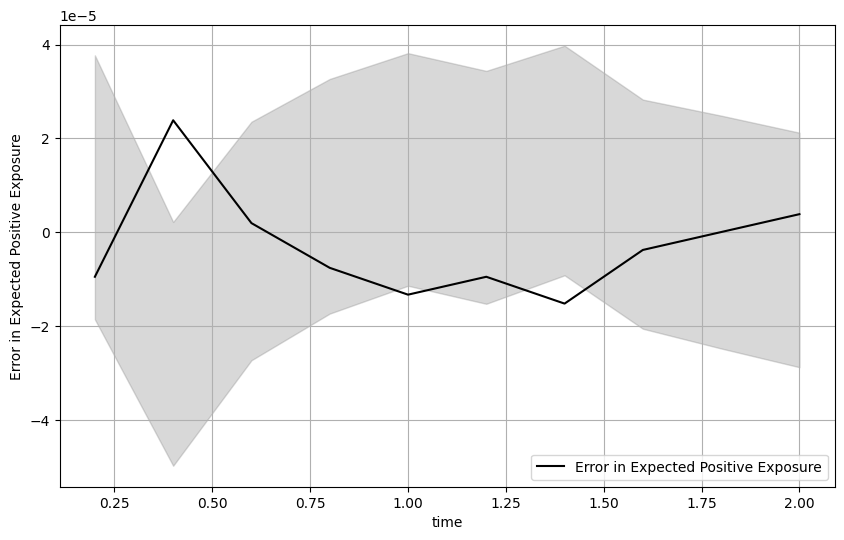

In [57]:
# Error plot
up = np.mean(pi['tilde'], axis=1) -np.mean(pi['exact'], axis=1)+2.0*np.sqrt(np.mean(pi['tilde_var'], axis=1))   # 95% confident interval 
down = np.mean(pi['tilde'], axis=1) -np.mean(pi['exact'], axis=1)- 2.0*np.sqrt(np.mean(pi['tilde_var'], axis=1))   # 95% confident interval 

plt.figure(figsize = (10,6),facecolor='white', edgecolor='black')
plt.plot(timegrid[1:], np.mean(pi['exact'], axis=1)-np.mean(pi['tilde'], axis=1), color = 'black', label = 'Error in Expected Positive Exposure')
plt.fill_between(timegrid[1:].flatten(), np.array(down), np.array(up), color = 'grey', alpha=0.3)
plt.grid(True)
plt.xlabel('time')
plt.ylabel('Error in Expected Positive Exposure')
plt.legend(loc = 'best', prop={'size':10})

## 2.2 - VaR

In [58]:
n_sim_dt = 100

# specify the portfolio
portfolio = {}
portfolio['call']={}
portfolio['put']={}

portfolio['call']['price']= lambda x,y: option_call.price(lb+(ub-lb)*x, y, True)
portfolio['put']['price']= lambda x,y: option_put.price(lb+(ub-lb)*x, y, True)
# portfolio['call']['price']= lambda x,y: bsformula(1, lb+(ub-lb)*x, KC, r, y, sigma, 0)[0]
# portfolio['put']['price']= lambda x,y: bsformula(-1, lb+(ub-lb)*x, KP, r, y, sigma, 0)[0]
portfolio['call']['weight']=2.0
portfolio['put']['weight']=-1.0

# prepare training and test data
training_number= 100
testing_number = 50

In [59]:
# Uniform sample
if not(smart_sampling):
    x_train = np.array(np.linspace(0.0,1.0, training_number), dtype='float32').reshape(training_number, 1)
    x_test = np.array(np.linspace(0.0,1.0, testing_number), dtype='float32').reshape(testing_number, 1)

# Chebychev sample
else:
    x_train = np.array(chebyshev_nodes(training_number), dtype='float32').reshape(training_number, 1)
    arr_min = np.min(x_train)
    arr_max = np.max(x_train)
    x_train = ((train_x_1_cheb - arr_min) / (arr_max - arr_min))[::-1]
    x_test = np.array(chebyshev_nodes(testing_number), dtype='float32').reshape(testing_number, 1)
    arr_min = np.min(x_test)
    arr_max = np.max(x_test)
    x_test = ((test_x_1_cheb - arr_min) / (arr_max - arr_min))[::-1]

In [60]:
sim_params = {}
model_params = {}
def_model = {}
  
model_params['r'] = r        # risk-free rate
model_params['sigma'] = sigma  # implied volatility
model_params['T'] = T        # Time to maturity 
model_params['t0'] = 0
model_params['S0'] = S0     # Underlying spot
     
# parameters of the default intensity model    
def_model['gamma_0'] = 0.01
def_model['gamma_1'] = 1.2
def_model['calibrate'] = False    # calibrate the prior \gamma_0 to spreads
def_model['recovery'] = 0.4
def_model['p'] = 0.05

sim_params['n_sim_dt'] = n_sim_dt # number of Euler stpes
sim_params['M']  = 100      # number of paths
sim_params['nt'] = nt        # number of exposure dates

timegrid = np.array(np.linspace(0.0,T,nt), dtype='float32').reshape(nt, 1)

sim_params['timegrid']= timegrid # time grid of exposure dates

In [ ]:
def trainGPs(x_train, f, timegrid):

    gps = []
    i = 0
    for time in timegrid:
        
        y_train = f(x_train.flatten(), float(time))
        
        sk_kernel = RBF(length_scale=1.0, length_scale_bounds=(0.01, 100.0))  #100000.0
        gp = gaussian_process.GaussianProcessRegressor(kernel=sk_kernel, n_restarts_optimizer=20)
        gp.fit(x_train,y_train)
        gps.append(gp)
        i += 1
    return gps   

def predictGPs(x_test, f, gps, timegrid):
    
    preds = []
    stds = []
    y_tests = []
    i = 0
    for time in timegrid:
        
        y_test= f(x_test.flatten(), float(time))
        y_tests.append(y_test)
        
        # Find optimal model hyperparameters
        # Set into eval mode
        pred, std = gps[i].predict(x_test,return_std=True)
        preds.append(pred)
        stds.append(std)
        i+=1
    return y_tests, preds, stds 

In [ ]:
kernel_name = 'Polynomial'
model = gpflow.models.GPR(
    (train_x_1, train_y_1.reshape(training_number, 1)),
    kernel=gpflow.kernels.Polynomial(), # SquaredExponential(),
)

opt = gpflow.optimizers.Scipy()
_ = opt.minimize(model.training_loss, model.trainable_variables)

y_pred_1, sigma_1 = model.predict_y(test_x_1)

y_pred_1_tf = y_pred_1.numpy().flatten()
sigma_1_tf = sigma_1.numpy().flatten()

In [ ]:
def trainGPs(x_train, f, timegrid):

    gps = []
    i = 0
    for time in timegrid:
        
        y_train = f(x_train.flatten(), float(time))
        
        gp = gpflow.models.GPR(
            (train_x_1, train_y_1.reshape(training_number, 1)),
            kernel=gpflow.kernels.SquaredExponential(
                lengthscales=1.0),
                )
        opt = gpflow.optimizers.Scipy()
        _ = opt.minimize(model.training_loss, model.trainable_variables)

        gp.fit(x_train,y_train)
        gps.append(gp)
        i += 1
    return gps   

def predictGPs(x_test, f, gps, timegrid):
    
    preds = []
    stds = []
    y_tests = []
    i = 0
    for time in timegrid:
        
        y_test= f(x_test.flatten(), float(time))
        y_tests.append(y_test)
        
        # Find optimal model hyperparameters
        # Set into eval mode
        pred, std = gps[i].predict(x_test,return_std=True)
        preds.append(pred)
        stds.append(std)
        i+=1
    return y_tests, preds, stds 

In [63]:
# train and predict over portfolio
for key in portfolio.keys():
    portfolio[key]['GPs'] = trainGPs(x_train, portfolio[key]['price'], timegrid)
    portfolio[key]['y_tests'], portfolio[key]['preds'], portfolio[key]['sigmas'] = predictGPs(x_test, portfolio[key]['price'], portfolio[key]['GPs'], timegrid)

In [64]:
def CVA_simulation(sim_params, model_params, def_model, recalibrate=False):
    
    n_sim_dt = sim_params['n_sim_dt'] # number of Euler stpes
    M        = sim_params['M']        # number of paths
    nt       = sim_params['nt']       # number of exposure dates
    timegrid = sim_params['timegrid'] # time grid of exposure dates
    
    r        = model_params['r']
    sigma    = model_params['sigma']
    T        = model_params['T'] 
    t0       = model_params['t0'] 
    S0       = model_params['S0'] 
    
    gamma_0  = def_model['gamma_0']
    gamma_1  = def_model['gamma_1']
    
    
    stride = n_sim_dt/(nt-1)
    idx = np.arange(0,n_sim_dt+1,stride, dtype=int)
    
    pi = {}
    pi['tilde'] = np.array([0.0]*(nt-1)*M, dtype='float32').reshape((nt-1), M)     # GP portfolio value
    pi['exact'] = np.array([0.0]*(nt-1)*M, dtype='float32').reshape((nt-1), M)     # BS portfolio value
    pi['tilde_var'] = np.array([0.0]*(nt-1)*M, dtype='float32').reshape((nt-1), M) # GP portfolio variance
    gamma = np.array([0.0]*(nt-1)*M, dtype='float32').reshape((nt-1), M)           # hazard rates
    dPD = np.array([0.0]*(nt-1)*M, dtype='float32').reshape((nt-1), M)             # default probabilities
    
    #simulate underlying GBM dynamics using Euler
    S = gbm(S0, r, sigma, T-t0, n_sim_dt, M)
    
    if (recalibrate):
        x  = np.exp(S0/S)**gamma_1
        # default probability (assumed to be estimated from credit spread)
        dt = timegrid[1]-timegrid[0] 
        f  = lambda y: np.abs(np.mean(np.prod(x**(-y*dt), axis=0)) - def_model['p']) 
        res = sp.optimize.basinhopping(f, 0.1, niter=10)
        i = 1   
        while (abs(res.fun) >1e-3):   
          res = sp.optimize.basinhopping(f, 0.1, niter=100*i)
          i *= 2
        gamma_0= res.x[0]
        print("calibration:", gamma_0, gamma_1, f(gamma_0), res.fun)  
    
    
    for m in range(M):  
      i = 1 
      exp_factor=1
        
      for time in timegrid[1:]:
        dt = timegrid[i]-timegrid[i-1] 
        
        S_= S[idx[i],m] # simulated S
        # avoid simulated S breaching boundaries of domain
        if (S_<lb):
            mins=S_
            S_=lb
        if (S_>ub):
            S_=ub
            maxs=S_
    
        pred_= 0
        v_ = 0
        var_ =0 
    
        for key in portfolio.keys():
           pred, std = portfolio[key]['GPs'][i].predict(np.array([(S_-lb)/(ub-lb)]).reshape(1,-1),return_std=True) 
           pred_ += portfolio[key]['weight']*pred
           var_ += (portfolio[key]['weight']*std)**2 
       
           if key=='call':
              v_ += portfolio[key]['weight']*option_call.price(float(S_), float(time), True) # bsformula(1, S_, KC, r, time, sigma, 0)[0] # -------------------------- 
           else:
              v_ += portfolio[key]['weight']*option_put.price(float(S_), float(time), True) # bsformula(-1, S_, KP, r, time, sigma, 0)[0] # --------------------------

        pi['tilde'][i-1,m] = np.maximum(pred_,0)
        pi['exact'][i-1,m] = np.maximum(v_,0)
        pi['tilde_var'][i-1,m] =var_ 
          
        # default intensity model
        gamma[i-1,m] = gamma_0*(S0/S_)**gamma_1    
        
        # compute default probabilities  
        exp_factor*=np.exp(-dt*gamma[i-1,m])    
        dPD[i-1,m]= gamma[i-1,m]*exp_factor
        
        i += 1
    # compute CVA
    i = 0
    CVA ={}
    CVA['tilde'] = 0
    CVA['exact'] = 0
    CVA['tilde_up'] = 0
    CVA['tilde_down'] = 0
    CVA['var_tilde'] =0
    
    if (recalibrate):
        CVA['gamma_0']=gamma_0
   
    for time in timegrid[1:]:
        dt = timegrid[i+1]-timegrid[i]
        CVA['tilde'] += np.mean(dPD[i,:]*pi['tilde'][i,:])*np.exp(-r*(time-t0))*dt
        CVA['var_tilde'] += np.var(dPD[i,:]*pi['tilde'][i,:]*np.exp(-r*(time-t0))*dt)
        CVA['exact'] += np.mean(dPD[i,:]*pi['exact'][i,:])*np.exp(-r*(time-t0))*dt
        i+=1
    
    CVA['tilde_up'] = (1-def_model['recovery'])*(CVA['tilde'] + 2*np.sqrt(CVA['var_tilde']/M))
    CVA['tilde_down'] = (1-def_model['recovery'])*(CVA['tilde'] - 2*np.sqrt(CVA['var_tilde']/M))
    CVA['tilde'] *= (1-def_model['recovery'])
    CVA['exact'] *= (1-def_model['recovery'])
    CVA['dPD'] = dPD
        
    return(CVA)

#### One year CVA with UQ

In [65]:
import warnings
warnings.filterwarnings('ignore')

J= 50 # number of outer simulations (from prior). Set J=1 for one year CVA without UQ
M = 50 # number of middle simulations. Set M= 0 for CVA_0 with UQ 
CVA_1 = []
CVA_0 = []
gamma_1= np.array([0.0]*J, dtype='float32')

# Sample from prior distribution using 
# non-centered chi-squared random variates
gamma_1 = (1.2 + 1.0*np.random.randn(J))**2 

for j in range(J): # outer loop
    print(j)
    def_model['gamma_0'] = 0.02
    def_model['gamma_1'] = gamma_1[j] 
    model_params['t0'] = 0.0
    sim_params['timegrid'] = timegrid
    CVA_0.append(CVA_simulation(sim_params, model_params, def_model, def_model['calibrate']))
    
    S = gbm(S0, r, sigma, 1.0, n_sim_dt, M)
    model_params['t0'] = 1.0
    sim_params['timegrid'] = timegrid[5:]
    for m in range(M): # middle loop
        model_params['S0'] = S[-1, m]
        CVA_1.append(CVA_simulation(sim_params, model_params, def_model))

warnings.resetwarnings()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


c:\Users\doret\Documents\GPflow\.venv\lib\site-packages\scipy\stats\_continuous_distns.py:795: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
c:\Users\doret\Documents\GPflow\.venv\lib\site-packages\scipy\stats\_continuous_distns.py:800: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  a, b = optimize.fsolve(func, (1.0, 1.0))


Text(0, 0.5, 'density')

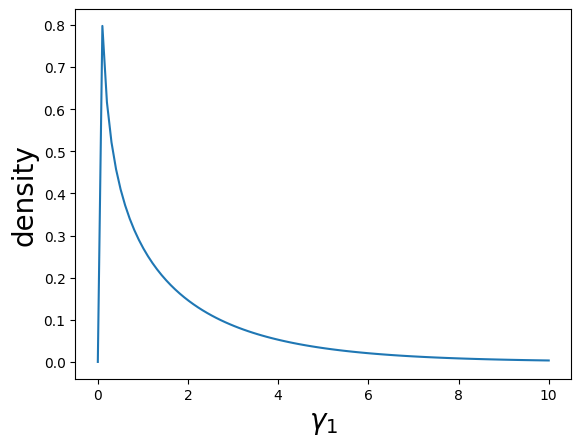

In [66]:
# plot fitted distribution of gamma_0
lnspc = np.linspace(0, 10.0, 100)
ab,bb,cb,db = stats.beta.fit(gamma_1)  
pdf_beta = stats.beta.pdf(lnspc, ab, bb,cb, db)  
plt.plot(lnspc, pdf_beta, label='$\\gamma_1$')
plt.xlabel('$\\gamma_1$', fontsize=20)
plt.ylabel('density', fontsize=20)

In [67]:
if (def_model['calibrate']):
    
    gamma_0= np.array([0.0]*J, dtype='float32')
    i=0
    for el in CVA_0:
      gamma_0[i]=el['gamma_0']
      i+=1
    lnspc = np.linspace(np.min(gamma_0)-10, np.max(gamma_0)+10, 100)
    
    ab,bb,cb,db = stats.beta.fit(gamma_0)  
    pdf_beta = stats.beta.pdf(lnspc, ab, bb,cb, db)  
    plt.plot(lnspc, pdf_beta, label='$\\gamma_0$')
    plt.xlabel('$\\gamma_0$')
    plt.ylabel('density')

In [68]:
i=0
CVA_0_tilde_UQ= np.array([0]*J, dtype='float32')
CVA_0_exact_UQ= np.array([0]*J, dtype='float32')
CVA_0_tilde_up_UQ= np.array([0]*J, dtype='float32')
CVA_0_tilde_down_UQ= np.array([0]*J, dtype='float32')


for el in CVA_0:
    CVA_0_tilde_UQ[i] = el['tilde']
    CVA_0_exact_UQ[i] = el['exact']
    CVA_0_tilde_up_UQ[i] = el['tilde_up']
    CVA_0_tilde_down_UQ[i] = el['tilde_down']
    i+=1

C:\Users\doret\AppData\Local\Temp\ipykernel_23772\1887508575.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  CVA_0_tilde_UQ[i] = el['tilde']
C:\Users\doret\AppData\Local\Temp\ipykernel_23772\1887508575.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  CVA_0_exact_UQ[i] = el['exact']
C:\Users\doret\AppData\Local\Temp\ipykernel_23772\1887508575.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  CVA_0_tilde_up_UQ[i] = el['tilde_up']
C:\Users\doret\AppData\Loc

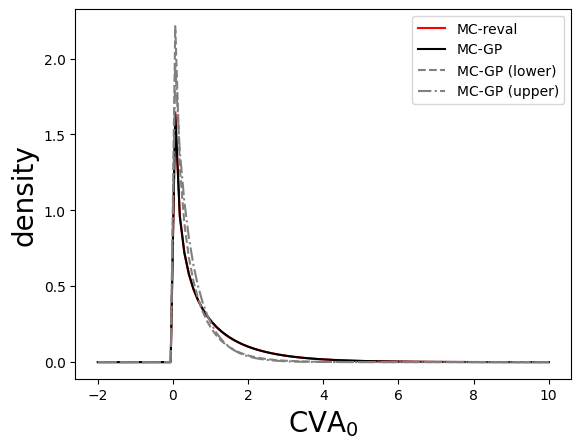

In [69]:
# CVA_0 with UQ
# plot one year incremental CVA distribution
lnspc = np.linspace(-2.0, 10, 100)

ab,bb,cb,db = stats.beta.fit(CVA_0_exact_UQ)  
pdf_beta = stats.beta.pdf(lnspc, ab, bb,cb, db)  
plt.plot(lnspc, pdf_beta, label='MC-reval', color='r')

ab,bb,cb,db = stats.beta.fit(CVA_0_tilde_UQ)  
pdf_beta = stats.beta.pdf(lnspc, ab, bb,cb, db)  
plt.plot(lnspc, pdf_beta, label='MC-GP', color='k')

ab,bb,cb,db = stats.beta.fit(CVA_0_tilde_down_UQ)  
pdf_beta = stats.beta.pdf(lnspc, ab, bb,cb, db)  
plt.plot(lnspc, pdf_beta, label='MC-GP (lower)', color="grey", linestyle='--')

ab,bb,cb,db = stats.beta.fit(CVA_0_tilde_up_UQ)  
pdf_beta = stats.beta.pdf(lnspc, ab, bb,cb, db)  
plt.plot(lnspc, pdf_beta, label='MC-GP (upper)', color='grey', linestyle='-.')

plt.xlabel('CVA$_0$', fontsize=20)
plt.ylabel('density', fontsize=20)
plt.legend()
plt.show()

<>:22: DeprecationWarning: invalid escape sequence '\g'
<>:22: DeprecationWarning: invalid escape sequence '\g'
C:\Users\doret\AppData\Local\Temp\ipykernel_23772\1030277759.py:22: DeprecationWarning: invalid escape sequence '\g'
  plt.xlabel('$\gamma_1$', fontsize=20)


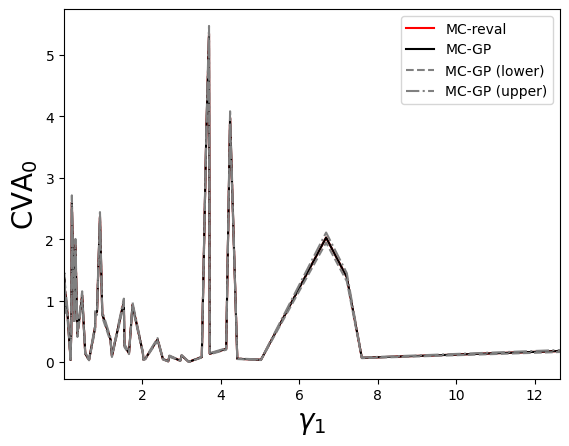

In [70]:
# plot CVA_0 against gamma_1

idx=np.argsort(gamma_1)

ab,bb,cb,db = stats.beta.fit(np.array(CVA_0_exact_UQ[idx]))  
pdf_beta = stats.beta.pdf(gamma_1[idx], ab, bb,cb, db)  
plt.plot(gamma_1[idx], CVA_0_exact_UQ[idx], label='MC-reval', color='r')

ab,bb,cb,db = stats.beta.fit(np.array(CVA_0_tilde_UQ[idx]))  
pdf_beta = stats.beta.pdf(gamma_1[idx], ab, bb,cb, db)  
plt.plot(gamma_1[idx], CVA_0_tilde_UQ[idx], label='MC-GP', color='k')

ab,bb,cb,db = stats.beta.fit(np.array(CVA_0_tilde_down_UQ[idx]))  
pdf_beta = stats.beta.pdf(gamma_1[idx], ab, bb,cb, db)  
plt.plot(gamma_1[idx], CVA_0_tilde_down_UQ[idx], label='MC-GP (lower)', color="grey", linestyle='--')

ab,bb,cb,db = stats.beta.fit(np.array(CVA_0_tilde_up_UQ[idx]))  
pdf_beta = stats.beta.pdf(gamma_1[idx], ab, bb,cb, db)  
plt.plot(gamma_1[idx], CVA_0_tilde_up_UQ[idx], label='MC-GP (upper)', color="grey", linestyle='-.')


plt.xlabel('$\gamma_1$', fontsize=20)
plt.xlim([np.min(gamma_1),np.max(gamma_1)])
plt.ylabel('CVA$_0$', fontsize=20)
plt.legend()
plt.show()


In [71]:
CVA_1_tilde_UQ = np.array([0.0]*J*M, dtype='float32').reshape(M, J)
CVA_1_tilde_up_UQ = np.array([0.0]*J*M, dtype='float32').reshape(M, J)
CVA_1_tilde_down_UQ = np.array([0.0]*J*M, dtype='float32').reshape(M, J)
CVA_1_exact_UQ = np.array([0.0]*J*M, dtype='float32').reshape(M, J)
i=0
for j in range(J):
    for m in range(M):
        el = CVA_1[i]
        CVA_1_tilde_UQ[m,j] = el['tilde']
        CVA_1_exact_UQ[m,j] = el['exact']
        CVA_1_tilde_up_UQ[m,j] = el['tilde_up']
        CVA_1_tilde_down_UQ[m,j] = el['tilde_down']
        i+=1

C:\Users\doret\AppData\Local\Temp\ipykernel_23772\1414066859.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  CVA_1_tilde_UQ[m,j] = el['tilde']
C:\Users\doret\AppData\Local\Temp\ipykernel_23772\1414066859.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  CVA_1_exact_UQ[m,j] = el['exact']
C:\Users\doret\AppData\Local\Temp\ipykernel_23772\1414066859.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  CVA_1_tilde_up_UQ[m,j] = el['tilde_up']
C:\Users\doret\AppDa

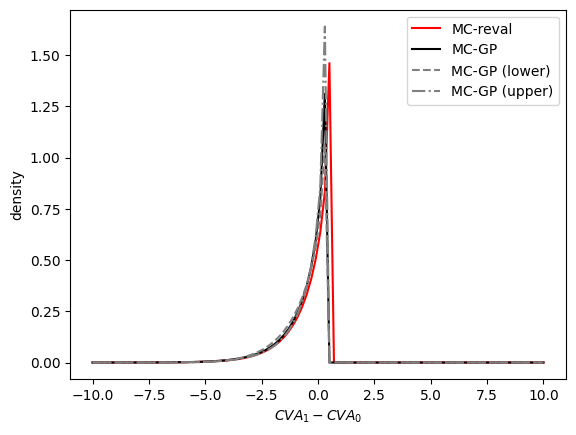

In [72]:
lnspc = np.linspace(-10, 10.0, 100)

ab,bb,cb,db = stats.beta.fit(np.mean(CVA_1_exact_UQ,axis=0)-CVA_0_exact_UQ)  
pdf_beta = stats.beta.pdf(lnspc, ab, bb,cb, db)  
plt.plot(lnspc, pdf_beta, label='MC-reval', color='r')

ab,bb,cb,db = stats.beta.fit(np.mean(CVA_1_tilde_UQ, axis=0)-CVA_0_tilde_UQ)  
pdf_beta = stats.beta.pdf(lnspc, ab, bb,cb, db)  
plt.plot(lnspc, pdf_beta, label='MC-GP', color='k')

ab,bb,cb,db = stats.beta.fit(np.mean(CVA_1_tilde_up_UQ, axis=0)-CVA_0_tilde_up_UQ)  
pdf_beta = stats.beta.pdf(lnspc, ab, bb,cb, db)  
plt.plot(lnspc, pdf_beta, label='MC-GP (lower)', color="grey", linestyle='--')

ab,bb,cb,db = stats.beta.fit(np.mean(CVA_1_tilde_down_UQ, axis=0)-CVA_0_tilde_down_UQ)  
pdf_beta = stats.beta.pdf(lnspc, ab, bb,cb, db)  
plt.plot(lnspc, pdf_beta, label='MC-GP (upper)', color='grey', linestyle='-.')

plt.xlabel('$CVA_1 - CVA_0$')
plt.ylabel('density')
plt.legend()
plt.show()

Text(0, 0.5, 'density')

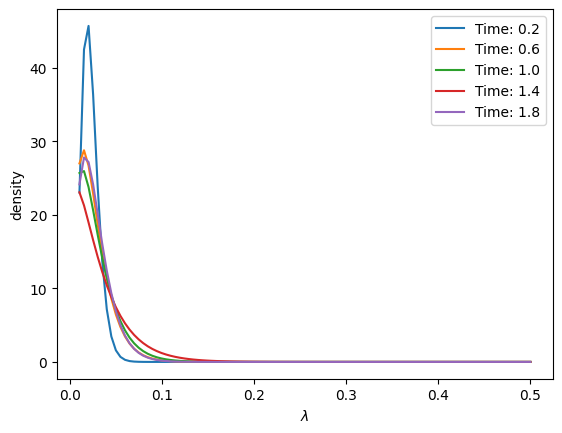

In [73]:
dPD = np.array([0.0]*(nt-1)*sim_params['M']*J, dtype='float32').reshape((nt-1), sim_params['M'],J)             # default probabilities
    

j=0 
for el in CVA_0:
    dPD[:,:,j] = el['dPD']
    j+=1

i=0    
for time in timegrid[1::2]:
    
# find minimum and maximum of xticks, so we know
# where we should compute theoretical distribution
    
    lnspc = np.linspace(0.01, 0.5, 100)

    ab,bb,cb,db = stats.beta.fit(dPD[i,:,:])  
    pdf_beta = stats.beta.pdf(lnspc, ab, bb,cb, db)  
    plt.plot(lnspc, pdf_beta, label='Time: ' + str(time[0]))
    i+=1
    
 
plt.legend()
plt.xlabel('$\\lambda$')
plt.ylabel('density')

#### CVA VaR

In [74]:
CVA_VaR = []
CVA_VaR_tilde = []
CVA_VaR_tilde_down = []
CVA_VaR_tilde_up = []



for j in range(J):
  CVA_1_exact = []
  CVA_1_tilde = []  
  CVA_1_tilde_up = []  
  CVA_1_tilde_down = []  
  for i in range(M):  
    CVA_1_exact.append(CVA_1[j*M + i]['exact'][0])
    CVA_1_tilde.append(CVA_1[j*M + i]['tilde'][0])
    CVA_1_tilde_up.append(CVA_1[j*M + i]['tilde_up'][0])
    CVA_1_tilde_down.append(CVA_1[j*M + i]['tilde_down'][0])
  
  #print(np.max(np.array(CVA_1_exact)), CVA_0[j]['exact'])
  s_sorted=np.sort(np.array(CVA_1_exact)-CVA_0[j]['exact'])
  s_sorted_tilde=np.sort(np.array(CVA_1_tilde)-CVA_0[j]['tilde'])
  s_sorted_tilde_down=np.sort(np.array(CVA_1_tilde_down)-CVA_0[j]['tilde_up'])
  s_sorted_tilde_up=np.sort(np.array(CVA_1_tilde_up)-CVA_0[j]['tilde_down'])
  quantiles = np.array([0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99,0.999])
  idx = np.array(len(s_sorted)*quantiles[9], dtype=int) 
  CVA_VaR.append(s_sorted[idx])
  CVA_VaR_tilde.append(s_sorted_tilde[idx])
  CVA_VaR_tilde_down.append(s_sorted_tilde_down[idx])
  CVA_VaR_tilde_up.append(s_sorted_tilde_up[idx])


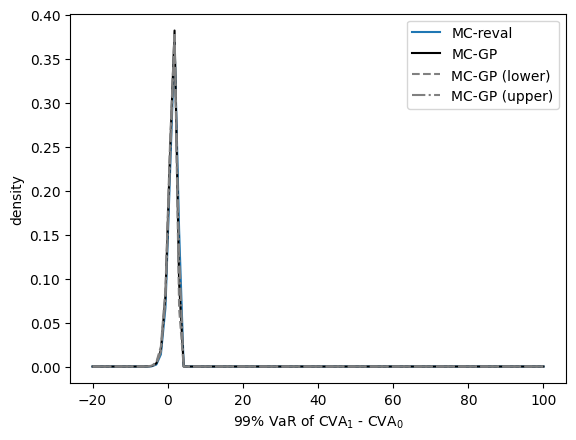

In [75]:
lnspc = np.linspace(-20, 100.0, 100)

ab,bb,cb,db = stats.beta.fit(np.array(CVA_VaR))  
pdf_beta = stats.beta.pdf(lnspc, ab, bb,cb, db)  
plt.plot(lnspc, pdf_beta, label='MC-reval')
ab,bb,cb,db = stats.beta.fit(np.array(CVA_VaR_tilde))  
pdf_beta = stats.beta.pdf(lnspc, ab, bb,cb, db)  
plt.plot(lnspc, pdf_beta, label='MC-GP', color='k')

ab,bb,cb,db = stats.beta.fit(np.array(CVA_VaR_tilde_down))  
pdf_beta = stats.beta.pdf(lnspc, ab, bb,cb, db)  
plt.plot(lnspc, pdf_beta, label='MC-GP (lower)', color="grey", linestyle='--')

ab,bb,cb,db = stats.beta.fit(np.array(CVA_VaR_tilde_up))  
pdf_beta = stats.beta.pdf(lnspc, ab, bb,cb, db)  
plt.plot(lnspc, pdf_beta, label='MC-GP (upper)', color='grey', linestyle='-.')

plt.xlabel('99% VaR of CVA$_1$ - CVA$_0$')
plt.ylabel('density')
plt.legend()

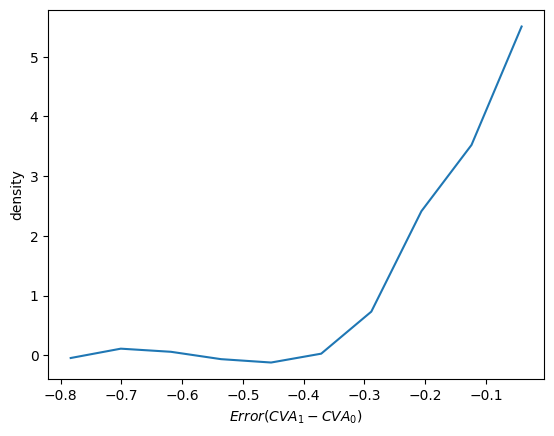

In [76]:
s = (CVA_1_tilde_UQ-CVA_0_tilde_UQ) - (CVA_1_exact_UQ - CVA_0_exact_UQ)   # generate your data sample with N elements
p, x = np.histogram(s, bins=10, density=True) # bin it into n = N//10 bins
x = x[:-1] + (x[1] - x[0])/2   # convert bin edges to centers
f = sp.interpolate.UnivariateSpline(x, p, s=1)
plt.plot(x, f(x))
plt.xlabel('$Error(CVA_1 - CVA_0)$')
plt.ylabel('density')
plt.show()